In [40]:
import sys
sys.path.append("../")
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, SAGPooling, ASAPooling
from src import graph_dataset, graph_trainer
import os
from src import visual
import h5py

In [64]:
class GCN(nn.Module):
    def __init__(self, pool='SAG', ratio=0.4, class_num=10):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(3, 16, add_self_loops = True, normalize = True)
        self.conv2 = GCNConv(16, 32, add_self_loops = True, normalize = True)
        self.conv3 = GCNConv(32, 64, add_self_loops = True, normalize = True)
        self.pool1 = SAGPooling(in_channels=32, ratio=ratio)
        self.pool2 = SAGPooling(in_channels=64, ratio=ratio)
        self.conv4 = GCNConv(64, 32, add_self_loops = True, normalize = True)
        self.conv5 = GCNConv(32, 32, add_self_loops = True, normalize = True)
        self.conv6 = GCNConv(32, class_num, add_self_loops = True, normalize = True)
        
        self.g = []
    def forward(self, x, edge_index, edge_attr):
        self.g.append((x, edge_index,edge_attr))
        print(x.shape)
        x = x.view(-1, 3)
        edge_index = edge_index.view(2, -1)
        edge_attr = edge_attr.view(-1)
        x = self.conv1(x, edge_index, edge_attr)
        x = F.relu(x)
        x = self.conv2(x, edge_index, edge_attr)
        x = F.relu(x)
        temp = self.pool1(x, edge_index, edge_attr)
        x, edge_index, edge_attr = temp[0], temp[1], temp[2]
        self.g.append((x, edge_index,edge_attr))
        
        x = self.conv3(x, edge_index, edge_attr)
        x = F.relu(x)
        temp = self.pool2(x, edge_index, edge_attr)
        x, edge_index, edge_attr = temp[0], temp[1], temp[2]
        self.g.append((x, edge_index,edge_attr))
        
        x = self.conv4(x, edge_index, edge_attr)
        x = F.relu(x)
        
        x = self.conv5(x, edge_index, edge_attr)
        x = F.relu(x)
        
        x = self.conv6(x, edge_index, edge_attr)
        x = F.relu(x)
        
        x = torch.max(x, dim=0, keepdim=True)[0]
        
        return F.log_softmax(x, dim=1), self.g


In [65]:
g_model = GCN()
g_model.load_state_dict(torch.load('../trained_models/modelnet_graph_k15.pt'))

<All keys matched successfully>

In [66]:
base = '../data/modelnet/modelnet_graph_k30/'
paths = []
labels = []
for obj in os.listdir(base):
    temp = base + obj
    for file in os.listdir(temp):
        if obj == 'airplane':
            paths.append(temp+'/' + file)
            labels.append(obj)

In [67]:
import h5py
f = h5py.File(paths[0], 'r')
edge_w = f['edge_weight'][:]
edges = f['edges'][:]
nodes = f['nodes'][:]
edges = torch.tensor(edges, dtype = torch.long)
x = torch.tensor(nodes, dtype=torch.float)
x = x.view(1, 1000, 3)
weights = torch.tensor(edge_w, dtype=torch.float)
f.close()

In [68]:
temp = g_model(x, edges, weights)[1]

torch.Size([1, 1000, 3])


In [69]:
temp

[(tensor([[[0.5390, 0.0984, 0.3636],
           [0.4347, 0.4795, 0.0823],
           [0.5346, 0.2321, 0.4206],
           ...,
           [0.5598, 0.4724, 0.3244],
           [0.5562, 0.3884, 0.3455],
           [0.5430, 0.2612, 0.4039]]]),
  tensor([[  0,   0,   0,  ..., 999, 999, 999],
          [  3,  15,  36,  ..., 935, 950, 968]]),
  tensor([0.0709, 0.0105, 0.0338,  ..., 0.0248, 0.0208, 0.0077])),
 (tensor([[0.0000e+00, 3.5793e-01, 0.0000e+00,  ..., 0.0000e+00, 8.0760e-01,
           0.0000e+00],
          [0.0000e+00, 3.3927e-01, 0.0000e+00,  ..., 0.0000e+00, 7.7382e-01,
           0.0000e+00],
          [0.0000e+00, 3.3925e-01, 0.0000e+00,  ..., 0.0000e+00, 7.7380e-01,
           0.0000e+00],
          ...,
          [5.5448e-02, 5.1094e-02, 0.0000e+00,  ..., 0.0000e+00, 1.7029e-01,
           0.0000e+00],
          [0.0000e+00, 1.6373e-01, 0.0000e+00,  ..., 0.0000e+00, 1.1712e-01,
           0.0000e+00],
          [5.3665e-04, 1.7754e-01, 0.0000e+00,  ..., 0.0000e+00, 1.0150e-0

In [55]:
first, second, third = temp[0], temp[1], temp[2]

In [84]:
nodes = first[0][0].numpy()

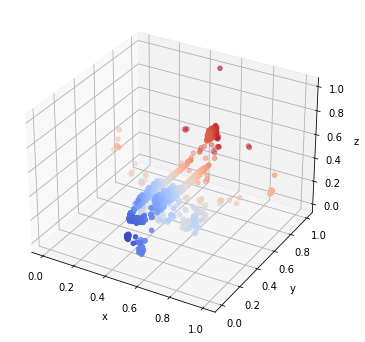

In [85]:
visual.visual(nodes)

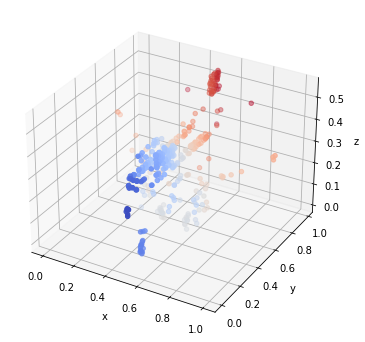

In [102]:
import numpy as np
temp = second[1].numpy()[0]
nodes_second = []
for i in range(1000):
    if i in temp:
        nodes_second.append(nodes[i])
visual.visual(np.array(nodes_second))

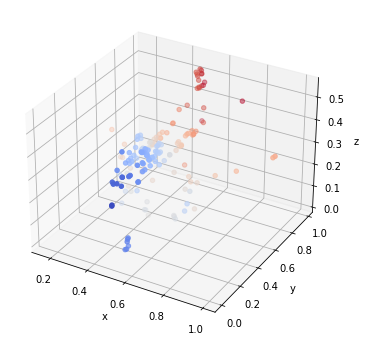

In [103]:
temp = third[1].numpy()[0]
nodes_third = []
for i in range(1000):
    if i in temp:
        nodes_third.append(nodes[i])
visual.visual(np.array(nodes_third))

In [104]:
first

(tensor([[[0.5390, 0.0984, 0.3636],
          [0.4347, 0.4795, 0.0823],
          [0.5346, 0.2321, 0.4206],
          ...,
          [0.5598, 0.4724, 0.3244],
          [0.5562, 0.3884, 0.3455],
          [0.5430, 0.2612, 0.4039]]]),
 tensor([[  0,   0,   0,  ..., 999, 999, 999],
         [  3,  15,  36,  ..., 935, 950, 968]]),
 tensor([0.0709, 0.0105, 0.0338,  ..., 0.0248, 0.0208, 0.0077]))

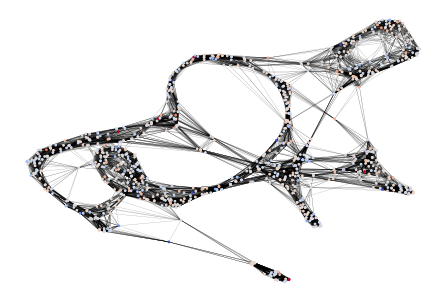

In [106]:
import networkx as nx
edges = first[1].numpy()
edge = []
for i in range(len(edges[0])):
    edge.append((edges[0][i], edges[1][i]))
G = nx.Graph()
G.add_edges_from(edge)
visual.draw_graph(G, nodes)

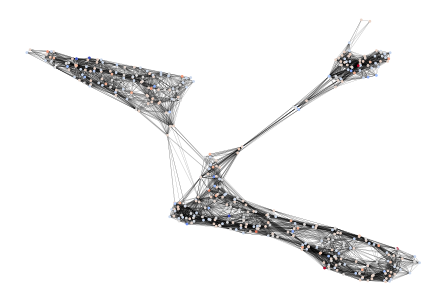

In [111]:
edges = second[1].numpy()
edge = []
for i in range(len(edges[0])):
    edge.append((edges[0][i], edges[1][i]))
G = nx.Graph()
G.add_edges_from(edge)
visual.draw_graph(G, np.array(nodes_second))

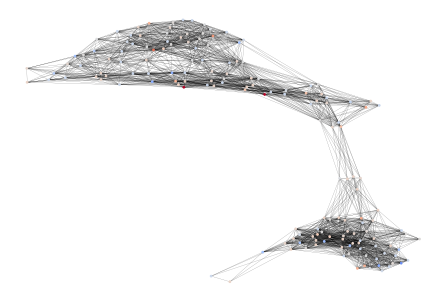

In [112]:
edges = third[1].numpy()
edge = []
for i in range(len(edges[0])):
    edge.append((edges[0][i], edges[1][i]))
G = nx.Graph()
G.add_edges_from(edge)
visual.draw_graph(G, np.array(nodes_third))